In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Data

In [2]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
 
print(data['DESCR'][200:1420])

 attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a 

In [3]:
from sklearn.model_selection import train_test_split
X = data['data']
y = data['target']
 
# Extracting the names of the features from data
features = data['feature_names']
 
# Splitting X & y into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.90, random_state=50)
 
# Creating a dataframe of the data, for a visual check
df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
df.columns = np.concatenate((features, np.array(['label'])))
print("Shape of data =", df.shape)
 
# Printing the top 5 rows of the dataframe
df.head()

Shape of data = (20640, 9)


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  label  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422

In [4]:
# Instantiate some prediction model (here: extra-trees regressor)
import xgboost
regressor = xgboost.XGBRegressor(random_state=50)

# fit prediction model to training data
regressor.fit(X_train, y_train)

# checking model performance on test data
print('R2 score for the model on test set =', regressor.score(X_test, y_test))

R2 score for the model on test set = 0.8167306181310772


In [5]:
regressor.predict(X_test)

array([2.5736806, 2.624859 , 1.7366142, ..., 1.3663929, 1.2009512,
       2.2463813], dtype=float32)

# SHAP

Avhengig av python/anaconda-system må du gjøre
conda install shap 
ELLER
pip install shap

In [6]:
import shap
shap.initjs() # Don't worry if this doesn't work for you. Comment it out and carry on

In [7]:
# Initialise explainer on a background data set, the data parameter.
# (this is the data that data to ble explained is compared against when calculating SHAP values)
explainer = shap.TreeExplainer(regressor, data=X_train)
# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

In [21]:
# Pick an instance to look closer at
y_pred = regressor.predict(X_test)
print("Mean price: ", np.mean(y_test))
print("Mean price prediction: ", np.mean(y_pred))

i = 6
print(f"\nLook closer at data point {i}:")
    
for _f, _x in zip(features, X_test[i]):
    print(f"{_f}: {_x}")

print("Actual price: ", y_test[i])
print("Predicted price: ", y_pred[i])
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test[i,:])

Mean price:  2.0812581734496125
Mean price prediction:  2.094418

Look closer at data point 6:
MedInc: 2.6328
HouseAge: 11.0
AveRooms: 4.1294387170675835
AveBedrms: 1.0080183276059564
Population: 3637.0
AveOccup: 4.166093928980527
Latitude: 33.89
Longitude: -118.17
Actual price:  1.607
Predicted price:  1.385024


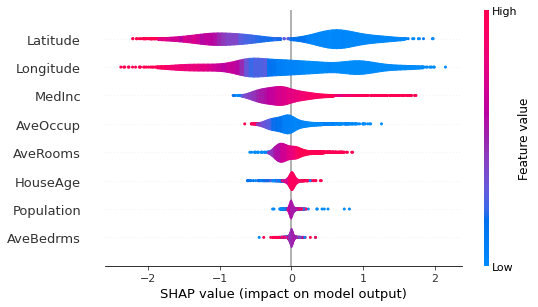

In [23]:
# Look at the whole data set
shap.summary_plot(shap_values, X_test, plot_type="violin", feature_names=features) 

# LIME

Avhengig av python/anaconda-system må du gjøre
conda install -c conda-forge lime 
ELLER
pip install lime

In [24]:
import lime.lime_tabular

# instantiate explainer object
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                        feature_names=features,
                                                        verbose=True, mode='regression')

In [25]:
# index in test array
i = 10

# number of top features
k = 5

# arguments to the explain_instance method:
# 1) ith test vector
# 2) prediction function to explain
# 3) top features to include
exp_lime = explainer_lime.explain_instance(X_test[i], regressor.predict, num_features=k)

# show explanations
exp_lime.show_in_notebook()

Intercept 2.2239936074196534
Prediction_local [3.70831349]
Right: 5.2523737


Interpreting the output:
Intercept: the constant in the linear model’s prediction for the test array
Prediction_local: value outputted by a linear model trained on the perturbed samples* using the top k features outputted by LIME
Right: prediction from our model for the test array

Visualisations: blue = negative; orange = positive contributions

*obtained by sampling around the test vector following a normal distribution